In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import itertools
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns

In [2]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:4


In [3]:
EMBEDDING_DIM = 20 # The dimension of the embeddings

class AutoEncoder(nn.Module):
    """
    A simple autoencoder for images. 
    self.linear1 generates the intermediate embeddings that we use for the normalizing flow.
    """
    def __init__(self):
        super().__init__()
        
        # Encoding layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        # Decoding layers
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

In [4]:
BATCH_SIZE = 100 # Batch size
# Load the dataset
train_set = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

test_set = datasets.MNIST('./data', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [5]:
AE_EPOCHS = 10 # Epochs for training the autoencoder
# We use a binary cross-entropy loss for the reconstruction error
loss_f = nn.BCELoss()

# Build the autoencoder
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(itertools.chain(autoencoder.parameters()),
                             lr=1e-3, weight_decay=1e-5)

for i in range(AE_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(train_loader):

        x, _ = data
        x = x.to(device)

        # Run the autoencoder
        _x, emb = autoencoder(x)
        _x = torch.sigmoid(_x)

        # Compute loss
        rec_loss = loss_f(_x, x)

        if batch_idx % 200 == 0:
            print(f"E {i}, {batch_idx:.3f}/{len(train_loader)}: Loss: {rec_loss.item()}")

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()

Epoch #1


/DKUdata/tangbl/anaconda/envs/bltang_new/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


E 0, 0.000/600: Loss: 0.6272263526916504


KeyboardInterrupt: 

In [6]:
# torch.save(autoencoder.state_dict(), "autoencoder.pth")
autoencoder.load_state_dict(torch.load("autoencoder.pth", map_location='cpu'))

<All keys matched successfully>

torch.Size([1, 1, 28, 28])


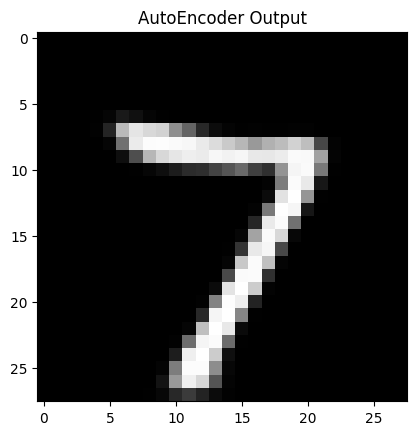

In [7]:
test_image = test_set[0][0].unsqueeze(0)
test_image = test_image.to(device)
_o, emb = autoencoder(test_image)
_o = torch.sigmoid(_o)
print(_o.shape)

## Display the image
plt.imshow(_o.squeeze().detach().cpu(), cmap='gray');
plt.title("AutoEncoder Output");

In [8]:
## 1. Extract all the data to embeddings
import tqdm

embs = []
with torch.no_grad():
    for data in tqdm.tqdm(train_loader):
        x, _ = data
        x = x.to(device)

        emb = autoencoder.encoder(x).cpu()
        for e in emb:
            embs.append(e)

print(len(embs))

100%|██████████| 600/600 [00:08<00:00, 66.97it/s]

60000


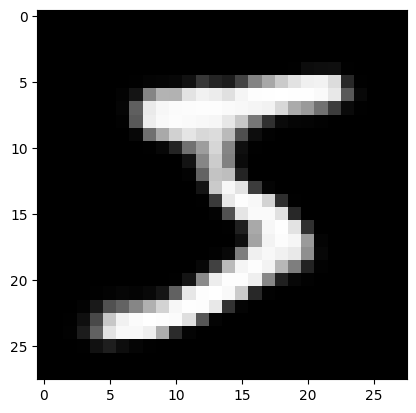

In [14]:
out = torch.sigmoid(autoencoder.decoder(embs[0].to(device)))
out.shape
plt.imshow(out[0][0].cpu().detach().numpy(), cmap='gray')

In [ ]:
emb_dataset = torch.utils.data.DataLoader(embs, batch_size=BATCH_SIZE, shuffle = True)

In [4]:
## Energy Models

class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[40, 10], output_dim=1): # the output dimension has to be 1d
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # logits for classification
        return x

In [6]:
model = MLP()
x = torch.randn([2, 1])
out = model(x)
out.shape

torch.Size([2, 1])

In [61]:
import tqdm
# def log_dist_prob(x):
#     # x: [D]
#     return -model(x) # [1]
def mala_sample(x, model, n_steps, n_sample_out, step = 0.2, verbose = False):

    def log_q_y_x(model, step, y, x):
        x.requires_grad_()
        out = model(x)
        grad = torch.autograd.grad(out, x)[0]
        norm = -torch.norm((y - x.detach() - step / 2 * grad), 2)**2 / (4 * step)
        return norm

    def log_accept_prob(model, z_new, z, step):
        left = model(z_new) -  model(z)
        right = log_q_y_x(model, step, z, z_new) - log_q_y_x(model,step, z_new, z)
        prob = left + right
        return min(0, prob)
    
    res = []
    
    z  = torch.clone(x)
   
    pbar = range(n_steps)
    if verbose:
        pbar = tqdm.tqdm(pbar)

    for _ in pbar:
        z.requires_grad_()
        out = model(z)
        grad = torch.autograd.grad(out, z)[0]
        z_new = z.detach() + step / 2 * grad + torch.randn(z.size(0), device=z.device) * np.sqrt(step)
        a_log_prob = log_accept_prob(model, z_new, z, step)
        if torch.log(torch.rand(1)).item() < a_log_prob:
            z = z_new
        res.append(z.detach())
        if verbose:
            pbar.set_description(f"z value {z}, a log prob: {a_log_prob}")
    return torch.stack(res, axis = 0)[-n_sample_out:]
    

def train_energy_model(model, optimizer, dataloader, mala_sample_fn, epoch = 10, device="cuda:0", log_interval = 100):
    model.to(device)
    for e in range(epoch):
        print(f"[Epoch {e}]")
        for bb, data in enumerate(dataloader):
            data = data.to(device)
            real_output = model(data).mean() # tensor()
            x_sample = mala_sample_fn(torch.randn(data.shape[-1], device = device), model = lambda x: -model(x)) # [B', 20]
            est_output = model(x_sample).mean() # tensor()
            loss =  real_output - est_output
            model.zero_grad()
            loss.backward()
            optimizer.step()

            if bb % log_interval == 0:
                print(f"[Epoch {e}] | [{bb}|{len(dataloader)}] loss: {loss.item()}")
    pass

In [62]:
# Generate fake gaussian dataset
BATCH_SIZE = 100
data = [torch.randn(1) for _ in range(60000)]
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle = True)

In [63]:
model = MLP()
optimzer = torch.optim.SGD(model.parameters(), lr = 1.0e-4)

mala_sample_fn = partial(mala_sample, n_steps = 50, n_sample_out = 10, step = 0.2)

train_energy_model(model, optimzer, dataloader, mala_sample_fn, epoch = 5)

[Epoch 0]
[Epoch 0] | [0|600] loss: -0.0724763423204422
[Epoch 0] | [100|600] loss: -0.1293853521347046
[Epoch 0] | [200|600] loss: 0.04373519867658615
[Epoch 0] | [300|600] loss: 0.06511157006025314
[Epoch 0] | [400|600] loss: -0.517440915107727
[Epoch 0] | [500|600] loss: 0.08902077376842499
[Epoch 1]
[Epoch 1] | [0|600] loss: -0.06520955264568329
[Epoch 1] | [100|600] loss: -0.005418643355369568


KeyboardInterrupt: 

In [58]:
model.to(device)
out = mala_sample(x = torch.randn(1, device = device), model = lambda x: -model(x), n_steps = 1000, n_sample_out = 100, step = 0.2, verbose = True)
out = out.cpu()

z value tensor([-0.6717], device='cuda:4', requires_grad=True), a log prob: tensor([-2.3055e-05], device='cuda:4', grad_fn=<AddBackward0>):   0%|          | 0/1000 [00:00<?, ?it/s]

z value tensor([-6.0840], device='cuda:4', requires_grad=True), a log prob: tensor([-0.0175], device='cuda:4', grad_fn=<AddBackward0>): 100%|██████████| 1000/1000 [00:06<00:00, 144.61it/s]   


In [59]:
out

tensor([[ -5.4433],
        [ -5.3610],
        [ -5.5237],
        [ -5.4671],
        [ -5.8351],
        [ -5.5344],
        [ -5.9060],
        [ -5.9069],
        [ -6.2186],
        [ -6.5069],
        [ -6.9296],
        [ -7.6025],
        [ -8.4267],
        [ -8.4431],
        [ -8.4418],
        [ -8.3669],
        [ -7.9522],
        [ -8.6830],
        [ -8.2739],
        [ -8.3452],
        [ -8.9463],
        [ -9.9488],
        [-10.0896],
        [ -9.3286],
        [ -9.0153],
        [ -8.9883],
        [ -9.4814],
        [ -9.2846],
        [ -8.7540],
        [ -8.9804],
        [ -9.1143],
        [ -8.5570],
        [ -8.5830],
        [ -8.5901],
        [ -8.5211],
        [ -8.2391],
        [ -7.9109],
        [ -7.1593],
        [ -6.6322],
        [ -6.3439],
        [ -6.4823],
        [ -6.5888],
        [ -6.2740],
        [ -6.6438],
        [ -6.8305],
        [ -6.8217],
        [ -7.6291],
        [ -7.7373],
        [ -7.9732],
        [ -7.7741],


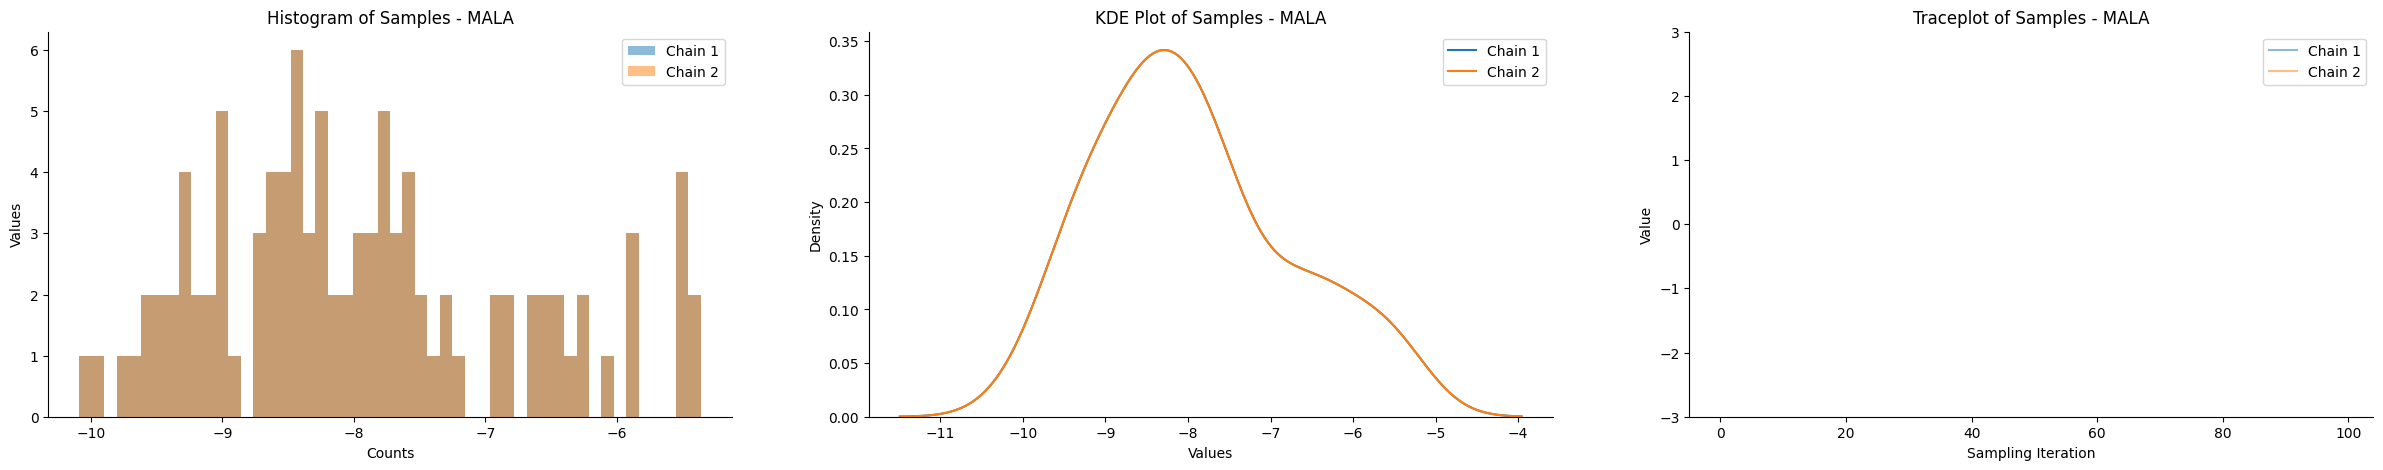

In [60]:
chain_1_MALA_1d = out
chain_2_MALA_1d = out
fig, ax = plt.subplots(1,3,figsize=(30,5))
ax[0].hist(chain_1_MALA_1d, bins=50, alpha=0.5, label='Chain 1')
ax[0].hist(chain_2_MALA_1d, bins=50, alpha=0.5, label='Chain 2')
ax[0].legend()
ax[0].set_xlabel('Counts')
ax[0].set_ylabel('Values')

# Assuming ax is your subplot axes
sns.kdeplot(chain_1_MALA_1d.reshape(-1), ax=ax[1], label='Chain 1')
sns.kdeplot(chain_2_MALA_1d.reshape(-1), ax=ax[1], label='Chain 2')

# Set labels and legend for the KDE plot
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Density')
ax[1].legend()


ax[2].plot(chain_1_MALA_1d, alpha=0.5, label='Chain 1')
ax[2].plot(chain_2_MALA_1d, alpha=0.5, label='Chain 2')
ax[2].set_ylim([-3,3])
ax[2].legend()
ax[2].set_xlabel('Sampling Iteration')
ax[2].set_ylabel('Value')

ax[0].set_title('Histogram of Samples - MALA')
ax[1].set_title('KDE Plot of Samples - MALA')
ax[2].set_title('Traceplot of Samples - MALA')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)

plt.show()

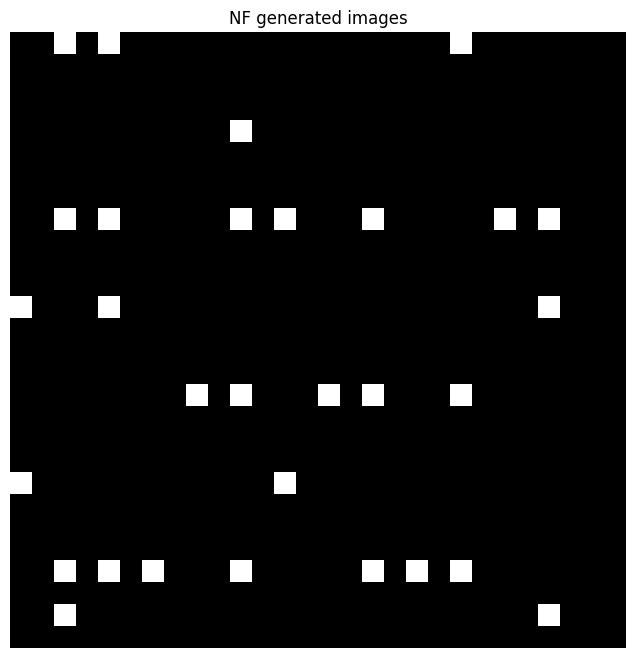

In [81]:
import torchvision.utils as vutils

## Display the image
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("NF generated images")
plt.imshow(np.transpose(vutils.make_grid(out.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

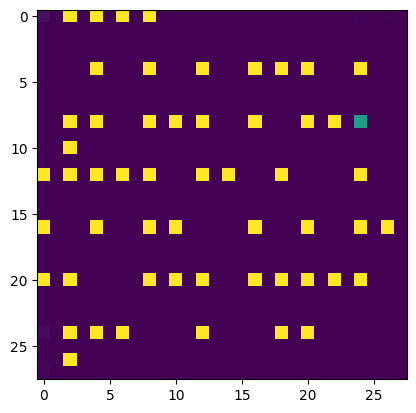

In [29]:
plt.imshow(out[0][0].cpu().detach().numpy())